
In the following, we run the simplest version of Deep Q-Learning. 

# Network Architecture

In [ ]:
import copy
import tensorflow as tf
import numpy as np

class Critic(tf.keras.Model):
    def __init__(self, action_dim):
        super(Critic, self).__init__()

        self.f1 = tf.keras.layers.Dense(256, activation='relu')
        self.f2 = tf.keras.layers.Dense(256, activation='relu')
        self.f3 = tf.keras.layers.Dense(action_dim, activation=None)

    def predict(self, state):
        q1 = self.f1(state)
        q1 = self.f2(q1)
        q1 = self.f3(q1)

        return q1

    def Q1(self, state):
        q1 = self.f1(state)
        q1 = self.f2(q1)
        q1 = self.f3(q1)

        return q1

# Agent Class

We then define the class for DQN. The update of the actor and critic is defined in "def train()".

In [ ]:
class DQN(object):
    def __init__(
            self,
            # h,
            # w,
            state_dim,
            action_dim,
            discount=0.99,
            tau=0.005,
            target_update = 10
    ):

        self.critic = Critic(action_dim)
        self.critic_target = copy.deepcopy(self.critic)
        self.critic_optimizer = tf.keras.optimizers.Adam(3e-4)
        self.critic.compile(optimizer=self.critic_optimizer)

        self.action_dim = action_dim
        self.discount = discount
        self.tau = tau

        self.target_update = target_update

        self.total_it = 0

    def select_action(self, state):
        state = tf.convert_to_tensor([state], dtype=tf.float32)
        action = tf.math.argmax(tf.squeeze(self.critic.predict(state), axis=1), 1)
        return action.numpy()[0]

    def train(self, replay_buffer, batch_size=128):
        self.total_it += 1

        # Sample replay buffer
        state, action_ind, next_state, reward, not_done = replay_buffer.sample(batch_size)

        action_ind = tf.cast(action_ind, tf.int32)

        index = tf.reshape(tf.range(0, batch_size), [batch_size, 1])
        index = tf.concat([index, action_ind], axis=1)


        with tf.GradientTape() as tape_critic:
            target_Q = self.critic_target.predict(next_state)
            target_Q_max = tf.math.reduce_max(target_Q, axis=1, keepdims=True)
            target_Q = reward + not_done * self.discount * target_Q_max

            current_Q = self.critic.predict(state)

            critic_loss = tf.keras.losses.MSE( tf.reshape(tf.gather_nd(current_Q,index), [batch_size, 1]), tf.stop_gradient(target_Q)) 

            grads_critic = tape_critic.gradient(critic_loss, self.critic.trainable_variables)

        self.critic_optimizer.apply_gradients(zip(grads_critic, self.critic.trainable_variables))

        if self.total_it % self.target_update == 0:
            self.critic_target.set_weights(self.critic.get_weights())

    def save_model(self, iter, seed, env_name, foldername='./model/dqn'):
        try:
            import pathlib
            pathlib.Path(foldername).mkdir(parents=True, exist_ok=True)
            self.critic.save_weights(
                foldername + '/DQN_' + env_name +
                '_seed' + str(seed) + '_iter' + str(iter) + '.tf')

            print('models is saved for iteration', iter)

        except:
            print("A result directory does not exist and cannot be created. The trial results are not saved")

    def load_model(self, iter, seed, env_name, foldername='model/dqn'):
        self.critic.load_weights(foldername + '/DQN_' + env_name +
                                '_seed' + str(seed) + '_iter' + str(iter) + '.tf')

# Replay Buffer

The samples collected through trials and errors are stored in the replay buffer. "def sample()" is a function that randomly samples a batch of samples from the replay buffer.

In [ ]:
class ReplayBuffer(object):
    def __init__(self, state_dim, action_dim, max_size=int(1e6)):
        self.max_size = max_size
        self.ptr = 0
        self.size = 0

        self.state = np.zeros((max_size, state_dim))
        self.action = np.zeros((max_size, action_dim))
        self.next_state = np.zeros((max_size, state_dim))
        self.reward = np.zeros((max_size, 1))
        self.not_done = np.zeros((max_size, 1))

    def add(self, state, action, next_state, reward, done):
        self.state[self.ptr] = state
        self.action[self.ptr] = action
        self.next_state[self.ptr] = next_state
        self.reward[self.ptr] = reward
        self.not_done[self.ptr] = 1. - done

        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample(self, batch_size):
        ind = np.random.randint(0, self.size, size=batch_size)

        return (
            tf.convert_to_tensor(self.state[ind], dtype=tf.float32),
            tf.convert_to_tensor(self.action[ind], dtype=tf.float32),
            tf.convert_to_tensor(self.next_state[ind], dtype=tf.float32),
            tf.convert_to_tensor(self.reward[ind], dtype=tf.float32),
            tf.convert_to_tensor(self.not_done[ind], dtype=tf.float32)
        )

# Training and Evaluating Procedures

We define a function for evaluating the policy. When evaluating the trained policy, we evaluate the performance without the exploration noise.

In [ ]:
def evaluate_greedy(env_test, agent, args, test_iter, test_n, state_dim):

    state_test = env_test.reset()
    return_epi_test = 0
    for t_test in range(int(args['max_episode_len'])):
        action_test = agent.select_action(np.reshape(state_test, (1, state_dim)))

        state_test2, reward_test, terminal_test, info_test = env_test.step(action_test)
        state_test = state_test2
        return_epi_test = return_epi_test + reward_test
        if terminal_test:
            break

    print('test_iter:{:d}, nn:{:d}, return_epi_test: {:d}'.format(int(test_iter), int(test_n),
                                                                      int(return_epi_test)))

    return return_epi_test

In [ ]:
def train(env, env_test, agent, args, index ):

    # Initialize replay memory
    total_step_cnt = 0
    epi_cnt = 0
    test_iter = 0
    return_test = np.zeros((np.ceil(int(args['total_step_num']) / int(args['eval_step_freq'])).astype('int') + 1))

    state_dim = env.observation_space.shape[0]
    action_dim =  env.action_space.n

    replay_buffer = ReplayBuffer(state_dim, 1)

    while total_step_cnt in range( int(args['total_step_num']) ):

        state = env.reset()
        ep_reward = 0
        T_end = False

        for t in range(int(args['max_episode_len'])):

            if args['render_env']:
                    env.render()

            # Select action randomly or according to policy
            rnd_sample = np.random.uniform(0,1)
            if total_step_cnt < int(args['start_timesteps']) or rnd_sample < 0.05:
                action = env.action_space.sample()

            else:
                action = agent.select_action(np.reshape(state, (1, state_dim)))

            state2, reward, done, _ = env.step(action)

            done = float(done) if t < int(args['max_episode_len']) else 1

            # Store data in replay buffer
            replay_buffer.add(state, action, state2, reward, done)

            # Move to the next state
            state = state2

            # Train agent after collecting sufficient data
            if total_step_cnt >= int(args['start_timesteps']):
                for i in range(int(args['update_freq'])):
                    agent.train(replay_buffer, int(args['batch_size']))

            if t == int(args['max_episode_len']) - 1:
                T_end = True

            ep_reward += reward
            total_step_cnt += 1

            # Evaluate the deterministic policy
            if total_step_cnt >= test_iter * int(args['eval_step_freq']) or total_step_cnt == 1:
                print('total_step_cnt', total_step_cnt)
                print('evaluating the deterministic policy...')
                for test_n in range(int(args['test_num'])):
                    return_epi_test = evaluate_greedy(env_test, agent, args, test_iter, test_n, state_dim)

                    # Store the average of returns over the test episodes
                    return_test[test_iter] = return_test[test_iter] + return_epi_test / float(args['test_num'])

                print('return_test[{:d}] {:d}'.format(int(test_iter), int(return_test[test_iter])))
                test_iter += 1

            if total_step_cnt % int(args['model_save_freq'])==0:
                    agent.save_model(iter=test_iter, seed=int(index), env_name=args['env'])


            if done or T_end:
                epi_cnt += 1
                print('| Reward: {:d} | Episode: {:d} | Total step num: {:d} |'.format(int(ep_reward), epi_cnt, total_step_cnt ))
                break

    return return_test

Main funciton. To manage the hyperparamters, we use argeparse.
We use a task in OpenAI Gym (https://gym.openai.com/).

In [ ]:
import numpy as np
import gym

import argparse

parser = argparse.ArgumentParser(description='provide arguments')

# run parameters
parser.add_argument('--env', help='choose the gym env- tested on {CartPole-v0}')
parser.add_argument('--env-id', type=int, default=0, help='choose the gym env- tested on {CartPole-v0}')
parser.add_argument('--random-seed', help='random seed for repeatability', default=1234)
parser.add_argument('--max-episode-len', help='max length of 1 episode', default=1000)
parser.add_argument('--trial-num', help='number of trials', default=3)
parser.add_argument('--render-env', help='render the gym env', default=False)
parser.add_argument('--total-step-num', help='total number of time steps', default=20000)
parser.add_argument('--eval-step-freq', help='frequency of evaluating the policy', default=5000)
parser.add_argument('--test-num', help='number of test episodes', default=10)

parser.add_argument('--result-file', help='file name for storing results from multiple trials',
                    default='/trials_dqn_')
parser.add_argument('--trial-idx', help='index of trials', default=0)
parser.add_argument('--video-dir', help='directory for recording', default='results/video/dqn')
parser.add_argument('--model-save-freq', help='frequency of evaluating the policy', default=20000)
parser.add_argument('--model-folder',  default='./model/dqn')
parser.add_argument("--save-video", default=False, type=bool)

parser.add_argument("--start_timesteps", default=1e4, type=int)  # How many time steps purely random policy is run for
parser.add_argument("--update_freq", default=1, type=int)  # Number of policy updates
parser.add_argument("--expl_noise", default=0.1, type=float)  # Std of Gaussian exploration noise
parser.add_argument("--batch_size", default=128, type=int)  # Batch size for both actor and critic
parser.add_argument("--discount", default=0.99, type=float)  # Discount factor
parser.add_argument("--tau", default=0.005, type=float)  # Target network update rate

args_tmp, unknown = parser.parse_known_args()

if args_tmp.env is None:
    env_dict = {0 : "CartPole-v0",
    }
    args_tmp.env = env_dict[args_tmp.env_id]
args = vars(args_tmp)

return_set = []
for ite in range(int(args['trial_num'])):
    print('Trial Number:', ite)

    index = int(ite) + int(args['trial_idx'])
    env = gym.make(args['env'])

    np.random.seed(index )
    env.seed(index)

    env_test = gym.make(args['env'])
    env_test.seed(index)

    state_dim = env.observation_space.shape[0]
    n_actions = env.action_space.n

    # if args['save_video']:
    #     env = gym.wrappers.Monitor(env, args['video_dir'], video_callable=lambda episode_id: episode_id % 1 == 0, force=True)

    agent = DQN(state_dim=state_dim, action_dim=n_actions, discount=args['discount'])

    step_R_i = train(env, env_test, agent, args, index)
    return_set.append(step_R_i)

    result_path = "./results/trials/dqn"
    result_filename = result_path + args['result_file'] +  args['env'] +  '_trial_idx_' + str(index) + '.txt'
    try:
        import pathlib
        pathlib.Path(result_path).mkdir(parents=True, exist_ok=True)
        np.savetxt(result_filename, np.asarray(step_R_i))
        print('The result of the trial no.' + str(index) +' was saved.')
    except:
        print("A result directory does not exist and cannot be created. The trial results are not saved")

Trial Number: 0
total_step_cnt 1
evaluating the deterministic policy...
test_iter:0, nn:0, return_epi_test: 10
test_iter:0, nn:1, return_epi_test: 9
test_iter:0, nn:2, return_epi_test: 8
test_iter:0, nn:3, return_epi_test: 8
test_iter:0, nn:4, return_epi_test: 8
test_iter:0, nn:5, return_epi_test: 9
test_iter:0, nn:6, return_epi_test: 10
test_iter:0, nn:7, return_epi_test: 9
test_iter:0, nn:8, return_epi_test: 10
test_iter:0, nn:9, return_epi_test: 9
return_test[0] 9
| Reward: 23 | Episode: 1 | Total step num: 23 |
| Reward: 19 | Episode: 2 | Total step num: 42 |
| Reward: 12 | Episode: 3 | Total step num: 54 |
| Reward: 12 | Episode: 4 | Total step num: 66 |
| Reward: 10 | Episode: 5 | Total step num: 76 |
| Reward: 16 | Episode: 6 | Total step num: 92 |
| Reward: 15 | Episode: 7 | Total step num: 107 |
| Reward: 15 | Episode: 8 | Total step num: 122 |
| Reward: 16 | Episode: 9 | Total step num: 138 |
| Reward: 10 | Episode: 10 | Total step num: 148 |
| Reward: 18 | Episode: 11 | Tota

We plot the results of the training using matplotlib.

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


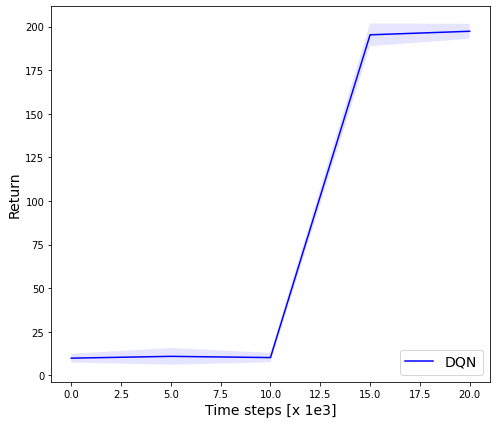

In [ ]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.rcParams['font.family'] = 'Times New Roman'

figure(figsize=(7, 6))

t = np.arange(0, int(args['total_step_num']) + 1, int(args['eval_step_freq'])) * 0.001

mean = np.mean(np.asarray(return_set), axis=0)
std = np.std(np.asarray(return_set), axis=0)
color = 'b'
label = 'DQN'
plt.plot(t, mean, color, label=label)
plt.fill(np.concatenate([t, t[::-1]]), np.concatenate([mean - 1.9600 * std,
                                      (mean + 1.9600 * std)[::-1]]), alpha=.1, fc=color, ec='None')

plt.xlabel('Time steps [x 1e3]', fontsize=14)
plt.ylabel('Return', fontsize=14)
plt.legend(loc='lower right', fontsize=14)

    
plt.tight_layout()
plt.show()